# Pix2Pix CycleGAN

Adapted from https://learnopencv.com/paired-image-to-image-translation-pix2pix/

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from torch.utils.data import DataLoader
from torch.autograd import Variable
import pandas as pd
import math

import torch.nn as nn
import torch.nn.functional as F
import torch
import numpy as np
import zipfile

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [3]:
if torch.cuda.is_available():
    device = 'cuda'
    #Tensor = torch.cuda.FloatTensor
else:
    device = 'cpu'
    #Tensor = torch.Tensor

# Fake Dataset

In [4]:
'''n_data=10000
control_data = torch.rand( (n_data, *control_shape)) #Uniform
signal_data = torch.randn((n_data, *signal_shape))  #Gaussian

val_control_data = torch.rand( (n_data, *control_shape)) #Uniform
val_signal_data = torch.randn((n_data, *signal_shape))  #Gaussian'''

'n_data=10000\ncontrol_data = torch.rand( (n_data, *control_shape)) #Uniform\nsignal_data = torch.randn((n_data, *signal_shape))  #Gaussian\n\nval_control_data = torch.rand( (n_data, *control_shape)) #Uniform\nval_signal_data = torch.randn((n_data, *signal_shape))  #Gaussian'

In [5]:
'''fake_dataset =torch.cat([signal_data,control_data],dim=1) #one block, signal data at channel 0, control data at channels >0
val_fake_dataset =torch.cat([val_signal_data,val_control_data],dim=1)
batch_size = 128'''

'fake_dataset =torch.cat([signal_data,control_data],dim=1) #one block, signal data at channel 0, control data at channels >0\nval_fake_dataset =torch.cat([val_signal_data,val_control_data],dim=1)\nbatch_size = 128'

## Real Dataset (too small for now)

In [6]:
df = pd.read_pickle('/content/drive/MyDrive/Dataset_0_100.pkl')
n_data=df.shape[0]
n_train=int(0.9*n_data)
batch_size = 24

In [7]:
#create a df with only aux channels
df_aux = pd.DataFrame(df[['V1:LSC_MICH_ERR', 'V1:LSC_NE_CORR']])

In [8]:
signal_data_train=torch.stack([torch.stack([df['V1:LSC_MICH_ERR'][i]]) for i in range(n_train)])
aux_data_train=torch.stack([torch.stack([df_aux.loc[i][0],df_aux.loc[i][1]]) for i in range(n_train)])
train_data=torch.cat([signal_data_train,aux_data_train],dim=1)
print(signal_data_train.shape)
print(aux_data_train.shape)

signal_data_test=torch.stack([torch.stack([df['V1:LSC_MICH_ERR'][i]]) for i in range(n_train,n_data)])
aux_data_test=torch.stack([torch.stack([df_aux.loc[i][0],df_aux.loc[i][1]]) for i in range(n_train,n_data)])
test_data=torch.cat([signal_data_test,aux_data_test],dim=1)
print(signal_data_test.shape)
print(aux_data_test.shape)

torch.Size([90, 1, 65536])
torch.Size([90, 2, 65536])
torch.Size([10, 1, 65536])
torch.Size([10, 2, 65536])


In [9]:
dataloader = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True,
)

In [10]:
test_dataloader = DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle=False,
)

## Model

In [11]:
def init_weights(net, init_type='normal', scaling=0.02):
    def init_func(m):  # define the initialization function
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv')) != -1:
            torch.nn.init.normal_(m.weight.data, 0.0, scaling)
        elif classname.find('BatchNorm2d') != -1:  # BatchNorm Layer's weight is not a matrix; only normal distribution applies.
            torch.nn.init.normal_(m.weight.data, 1.0, scaling)
            torch.nn.init.constant_(m.bias.data, 0.0)

    print('initialize network with %s' % init_type)
    net.apply(init_func)  # apply the initialization function

## Generator

### Convolutional UNet

In [12]:
class Decoder(nn.Module):
    def __init__(self, in_channels, kernel_size=5):
        super(Decoder, self).__init__()

        self.conv1 = nn.Conv1d(in_channels, 64, kernel_size=kernel_size, stride=1, padding=kernel_size//2)
        self.relu1 = nn.LeakyReLU(0.2, inplace=True)

        self.conv2 = nn.Conv1d(64, 128,kernel_size=kernel_size, stride=1, padding=kernel_size//2)
        self.relu2 = nn.LeakyReLU(0.2, inplace=True)

        self.conv3 = nn.Conv1d(128, 256,kernel_size=kernel_size, stride=1, padding=kernel_size//2)
        self.relu3 = nn.LeakyReLU(0.2, inplace=True)

        self.conv4 = nn.Conv1d(256, 1, kernel_size=kernel_size, stride=1, padding=kernel_size//2)

    def _forward_features(self, x):
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.conv2(x))
        x = self.relu3(self.conv3(x))
        x = self.conv4(x)
        return x

    def forward(self, x):
        return self._forward_features(x)

In [13]:
'''
model=Decoder(2).to(device)
for batch in dataloader:
    target = batch[:,0].unsqueeze(1).to(device)
    input = batch[:,1:].to(device)
    out=model(input)
    print(out.shape)
    print(input.shape)
    print((out-target).sum())
    break'''

'\nmodel=Decoder(2).to(device)\nfor batch in dataloader:\n    target = batch[:,0].unsqueeze(1).to(device)\n    input = batch[:,1:].to(device)\n    out=model(input)\n    print(out.shape)\n    print(input.shape)\n    print((out-target).sum())\n    break'

In [14]:
def make_conv_net(hidden_sizes, kernel_size, in_channels, out_channels):
    '''
    Convolutionaal Neural Netowrk
    hiddens_sizes=[N_filters for hidden layer 1, .... ,N_filters for hidden layer n]
    num hidden layers = len(hidden_sizes)
    '''
    sizes = [in_channels] + hidden_sizes + [out_channels]
    net = []
    for i in range(len(sizes) - 1):
        conv = torch.nn.Conv1d(sizes[i], sizes[i+1], kernel_size[i], padding=kernel_size[i]//2, stride=1, padding_mode='zeros',dilation=1)
        net.append(conv)
        if i != len(sizes) - 2:
            net.append(torch.nn.LeakyReLU(0.2))
    return torch.nn.Sequential(*net)


In [15]:
def train_decoder(num_epochs,generator,criterion,optimizer,dataloader,val_loader):
    loss_plot =[]
    val_loss_plot =[]
    for epoch in tqdm(range(1,num_epochs+1)):
        epoch_loss =[]
        for i, batch in enumerate(dataloader):
            target = batch[:,0].unsqueeze(1).to(device)
            input = batch[:,1:].to(device)
            optimizer.zero_grad()
            generated = generator(input)
            loss=criterion(generated,target)
            loss.backward()
            optimizer.step()
            epoch_loss.append(loss.detach().cpu().numpy())
        val_loss =[]
        for batch in(val_loader):
            target = batch[:,0].unsqueeze(1).to(device)
            input = batch[:,1:].to(device)
            with torch.no_grad():
                generated = generator(input)
                loss=criterion(generated,target)
                val_loss.append(loss.detach().cpu().numpy())
        loss_plot.append(np.mean(epoch_loss))
        val_loss_plot.append(np.mean(val_loss))
        if epoch%10==0:
          print('epoch: {} loss: {} val loss: {}'.format(epoch,loss_plot[-1],val_loss_plot[-1]))
    return loss_plot, val_loss_plot

def log_cosh_loss(y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
    def _log_cosh(x: torch.Tensor) -> torch.Tensor:
        return x + torch.nn.functional.softplus(-2. * x) - math.log(2.0)
    return torch.mean(_log_cosh(y_pred - y_true))

class LogCoshLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(
        self, y_pred: torch.Tensor, y_true: torch.Tensor
    ) -> torch.Tensor:
        return log_cosh_loss(y_pred, y_true)
def generate_data(generator,batch):
    target = batch[:,0].unsqueeze(1).to(device)
    input = batch[:,1:].to(device)
    with torch.no_grad():
        generated = generator(input)
    return generated


In [16]:
hidden_sizes=[64,128,256] #Numero di kernel per hidden layer
kernels=[5,5,5,5] #dimensione dei kernel per ogni layer (compreso l'output)
#generator=make_conv_net(hidden_sizes, kernels, 2, 1).to(device)

In [17]:
generator = Decoder(2).to(device)
init_weights(generator, 'normal', scaling=0.02)
print(generator)

initialize network with normal
Decoder(
  (conv1): Conv1d(2, 64, kernel_size=(5,), stride=(1,), padding=(2,))
  (relu1): LeakyReLU(negative_slope=0.2, inplace=True)
  (conv2): Conv1d(64, 128, kernel_size=(5,), stride=(1,), padding=(2,))
  (relu2): LeakyReLU(negative_slope=0.2, inplace=True)
  (conv3): Conv1d(128, 256, kernel_size=(5,), stride=(1,), padding=(2,))
  (relu3): LeakyReLU(negative_slope=0.2, inplace=True)
  (conv4): Conv1d(256, 1, kernel_size=(5,), stride=(1,), padding=(2,))
)


In [18]:
# loss function and optimiser

#criterion = torch.nn.L1Loss()
criterion = LogCoshLoss()

#criterion = nn.MSELoss()

lr=0.0005

G_optimizer = torch.optim.Adam(generator.parameters(), lr=lr )

In [19]:
n_epochs=500

In [20]:
loss_plot, val_loss_plot =train_decoder(500,generator,criterion,G_optimizer,dataloader,test_dataloader)

  0%|          | 0/500 [00:00<?, ?it/s]

epoch: 10 loss: 0.000313559896312654 val loss: 0.001105043338611722
epoch: 20 loss: 3.140529588563368e-05 val loss: 0.00019739831623155624
epoch: 30 loss: 7.993390681804158e-06 val loss: 0.00013727521582040936
epoch: 40 loss: 5.403541763371322e-06 val loss: 0.00014127603208180517
epoch: 50 loss: 4.207603069517063e-06 val loss: 0.00012301297101657838
epoch: 60 loss: 5.920564944972284e-06 val loss: 0.00011325214290991426
epoch: 70 loss: 1.6224055798375048e-05 val loss: 0.00013891462003812194
epoch: 80 loss: 3.024319539690623e-06 val loss: 0.00011493424244690686
epoch: 90 loss: 1.074429110303754e-05 val loss: 0.00013135524932295084
epoch: 100 loss: 7.368618753389455e-06 val loss: 0.0001218753750436008
epoch: 110 loss: 2.070915115837124e-06 val loss: 0.00010718011617427692
epoch: 120 loss: 1.7584715124030481e-06 val loss: 9.969971142709255e-05
epoch: 130 loss: 3.4502227208577096e-05 val loss: 0.00014536250091623515
epoch: 140 loss: 2.9018171971983975e-06 val loss: 0.00010225563164567575
ep

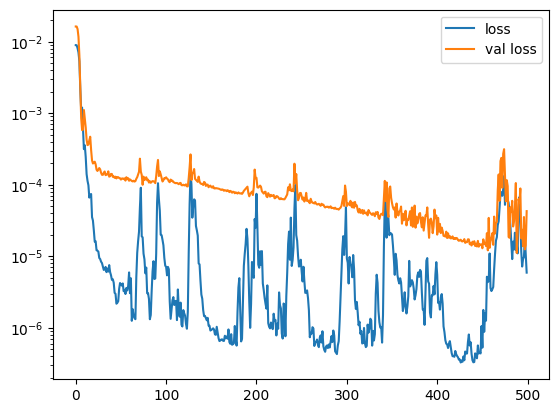

In [21]:
plt.plot(loss_plot,label='loss')
plt.plot(val_loss_plot,label='val loss')
plt.yscale('log')
plt.legend()

# Plotting The Syntetic Signals

In [22]:
try:
    from gwpy.timeseries import TimeSeries
except ModuleNotFoundError:
    !pip install --quiet gwpy
    from gwpy.timeseries import TimeSeries

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [23]:
for batch in(tqdm(test_dataloader)):
    generated=generate_data(generator,batch)
    break

  0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
n_data=10

/usr/local/lib/python3.10/dist-packages/gwpy/signal/qtransform.py:124: UserWarning: upper frequency of 2048.00 is too high for the given Q range, resetting to 1291.05
  warnings.warn('upper frequency of %.2f is too high for the given '
/usr/local/lib/python3.10/dist-packages/gwpy/signal/qtransform.py:124: UserWarning: upper frequency of 2048.00 is too high for the given Q range, resetting to 1291.05
  warnings.warn('upper frequency of %.2f is too high for the given '


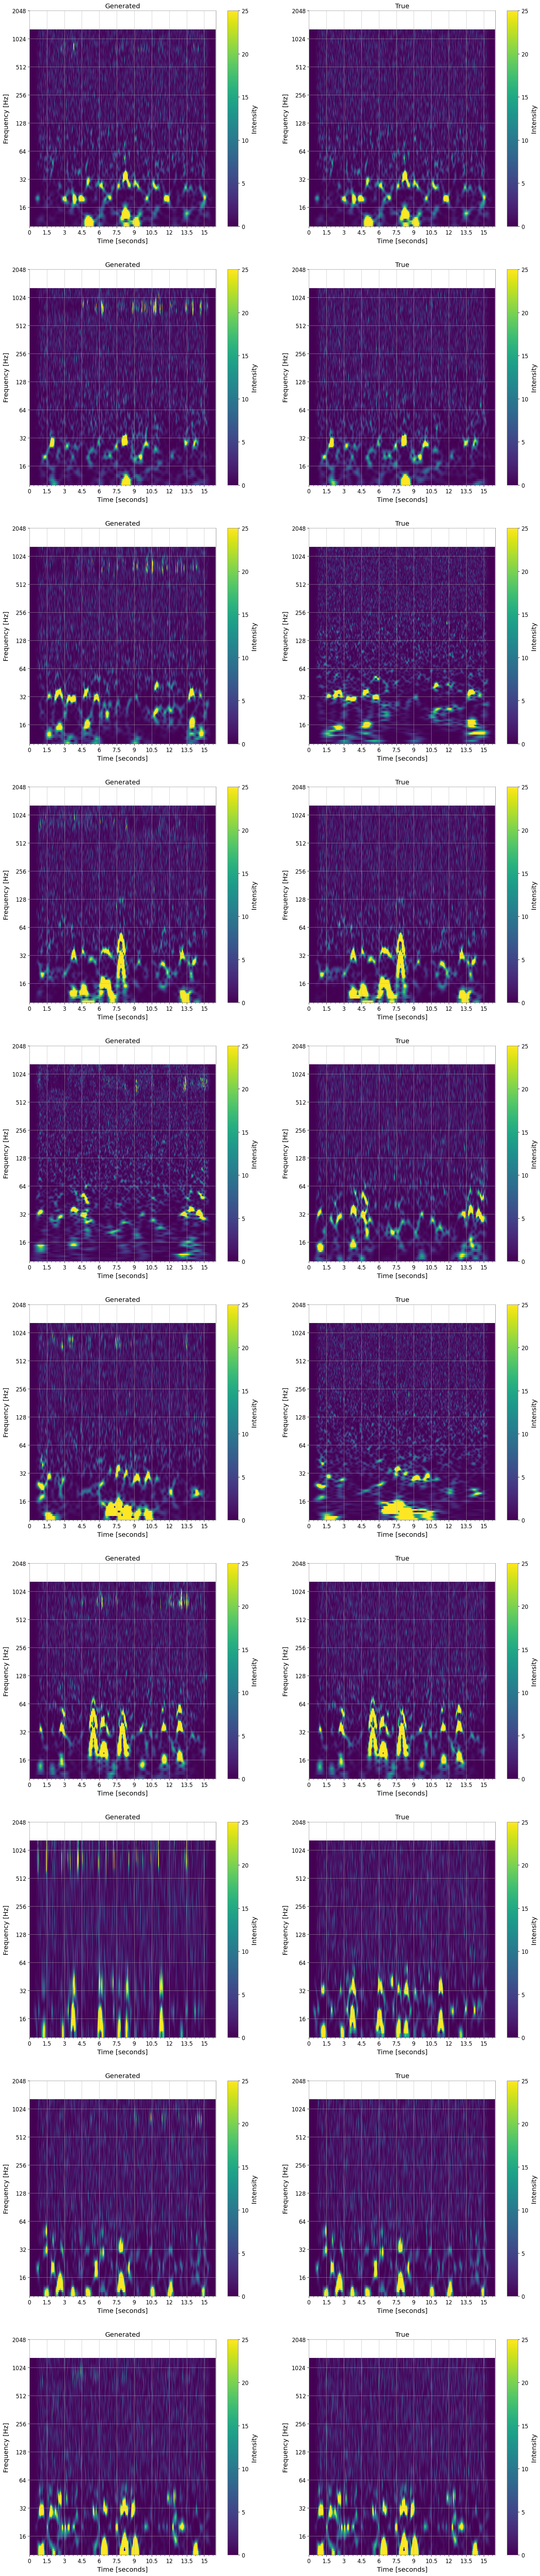

In [25]:
fig, ax = plt.subplots(n_data,2,figsize=[20, n_data*10])
for i in range(n_data):
    tmsrs=TimeSeries(generated[i][0].cpu().numpy())
    tmsrs.dt=1.0/4096.0
    tmsrs=tmsrs.whiten()
    qspecgram = tmsrs.q_transform(frange=(10,2048))
    plot = ax[i,0].imshow(qspecgram, cmap='viridis', aspect='auto', origin='lower', vmin=0, vmax=25)
    # Set x-axis scale to seconds
    ax[i,0].set_xscale('seconds')

    # Set y-axis scale to log with base 2
    ax[i,0].set_yscale('log', base=2)
    ax[i,0].set_ylim(10, 2048)
    #ax.set_xlim(gps-2, gps+2)

    # Set labels and colorbar
    ax[i,0].set_ylabel('Frequency [Hz]')
    cbar = plt.colorbar(plot, label='Intensity')


    tmsrs=TimeSeries(batch[i][0].cpu().numpy())
    tmsrs.dt=1.0/4096.0
    tmsrs=tmsrs.whiten()
    qspecgram = tmsrs.q_transform(frange=(10,2048))
    plot = ax[i,1].imshow(qspecgram, cmap='viridis', aspect='auto', origin='lower', vmin=0, vmax=25)
    # Set x-axis scale to seconds
    ax[i,1].set_xscale('seconds')

    # Set y-axis scale to log with base 2
    ax[i,1].set_yscale('log', base=2)
    ax[i,1].set_ylim(10, 2048)
    #ax.set_xlim(gps-2, gps+2)

    # Set labels and colorbar
    ax[i,1].set_ylabel('Frequency [Hz]')
    cbar = plt.colorbar(plot, label='Intensity')

    ax[i,0].set_title('Generated')
    ax[i,1].set_title('True')
    ax[i,0].set_xlabel('Time [seconds]')
    ax[i,1].set_xlabel('Time [seconds]')
plt.savefig('glitch.pdf')
plt.show()